In [4]:
import json

import numpy as np


class Feature:
    def __init__(
            self,
            vocab_path="../configs/vocab.json",
            feature_type_path="../configs/feature_type.json"
    ):
        with open(vocab_path) as f:
            self.vocab = json.load(f)

        with open(feature_type_path) as f:
            self.feature_vocab = json.load(f)

    def input_from_raw(self, raw_seq):
        features, duration = self.extract(raw_seq)

        return self.input_from_feature(features)

    def input_from_feature(self, features):
        raise NotImplementedError

    def extract_key(self, sub_seq):
        raise NotImplementedError

    def agg_feature(self, feature, features=None):
        raise NotImplementedError

    def extract(self, raw_seq):
        raw_seq = Feature.clean_raw_seq(raw_seq)
        duration = (raw_seq[-1]['time'] - raw_seq[0]['time'])

        features = None
        for i in range(len(raw_seq)):
            features = self.agg_feature(self.extract_key(raw_seq[i:]), features)

        return features, duration

    @staticmethod
    def clean_raw_seq(data):
        data = sorted(data, key=lambda x: x["time"])

        i = 0
        while i < len(data):
            if "keycode" not in data[i]:
                data.pop(i)
                continue
            i += 1

        return data


class AnonymousSeqFeature(Feature):
    def input_from_feature(self, features, duration=None, norm=None):
        steps = []

        for feature in features:
            step = [None for _ in feature]
            step[self.feature_vocab["DD"]["index"]] = feature["DD"]
            step[self.feature_vocab["DU"]["index"]] = feature["DU"]
            step[self.feature_vocab["UD"]["index"]] = feature["UD"]
            step[self.feature_vocab["UU"]["index"]] = feature["UU"]
            step[self.feature_vocab["Hold"]["index"]] = feature["Hold"]

            steps.append(step)

        steps = np.array(steps)
        if np.max(steps) > 1500:
            return

        # normalize
        # steps = steps * len(steps) / duration

        if norm == 'max':
            res = steps / np.max(steps)
        elif norm == 'min_max':
            res = (steps - np.min(steps)) / (np.max(steps) - np.min(steps))
        elif norm == 'none':
            res = steps / 1000.
        else:
            res = steps
#             raise ValueError("Must norm")

        if np.isnan(res).any():
            print(steps)
        return res

    def extract_key(self, sub_seq):
        features = dict()
        source_down = {}
        source_up = {}
        target_down = {}
        target_up = {}

        for step_idx, step in enumerate(sub_seq):
            if step["type"] == "down":
                if not source_down:
                    source_down = step
                    continue

                if not target_down:
                    target_down = step
                    continue

            if step["type"] == "up":
                if step_idx == 0:
                    return {}

                if (not source_up) and source_down and (step["keycode"] == source_down["keycode"]):
                    source_up = step
                    continue

                if (not target_up) and target_down and (step["keycode"] == target_down["keycode"]):
                    target_up = step
                    continue

            if source_down and source_up and target_down and target_up:
                break

        if (not source_down) or (not source_up) or (not target_down) or (not target_up):
            return {}

        features["DD"] = target_down["time"] - source_down["time"]
        features["DU"] = target_up["time"] - source_down["time"]
        features["UD"] = target_down["time"] - source_up["time"]
        features["UU"] = target_up["time"] - source_up["time"]
        features["Hold"] = source_up["time"] - source_down["time"]

        return features

    def agg_feature(self, feature, features=None):
        if not features:
            features = list()

        if feature:
            features.append(feature)

        return features


In [5]:
data_dir = "/home/hoang/Downloads/data/PolitehnicaUniversityTimisoaraKeystrokeDataSet/"

In [6]:
import os

In [7]:
for user_file in sorted(os.listdir(data_dir)):
    user_file = os.path.join(data_dir, user_file)
    with open(user_file) as f:
        data = [list(map(int, line.strip().split())) for line in f]
    new_data = []
    for ls in data:
        if ls[1] == 0:
            typing = 'down'
        elif ls[1] == 1:
            typing = 'up'
        else:
            raise
        d = {'keycode': ls[0], 'type': typing, 'time': ls[2]}
        new_data.append(d)
    data = new_data
    
    # split data
    new_data = []
    action = []
    prev = None
    
    for d in data:
        if prev is not None:
            if d['time'] - prev['time'] <= 1500:
                action.append(d)
            else:
                new_data.append(action)
                action = []
        else:
            action.append(d)
        prev = d

    break

In [8]:
action

[{'keycode': 32, 'type': 'up', 'time': 1526360},
 {'keycode': 80, 'type': 'down', 'time': 1526490},
 {'keycode': 80, 'type': 'up', 'time': 1526597},
 {'keycode': 82, 'type': 'down', 'time': 1526600},
 {'keycode': 82, 'type': 'up', 'time': 1526687},
 {'keycode': 73, 'type': 'down', 'time': 1526737},
 {'keycode': 69, 'type': 'down', 'time': 1526818},
 {'keycode': 73, 'type': 'up', 'time': 1526869},
 {'keycode': 69, 'type': 'up', 'time': 1526939},
 {'keycode': 84, 'type': 'down', 'time': 1527019},
 {'keycode': 69, 'type': 'down', 'time': 1527127},
 {'keycode': 84, 'type': 'up', 'time': 1527128},
 {'keycode': 69, 'type': 'up', 'time': 1527215},
 {'keycode': 78, 'type': 'down', 'time': 1527276},
 {'keycode': 78, 'type': 'up', 'time': 1527398},
 {'keycode': 73, 'type': 'down', 'time': 1527401},
 {'keycode': 73, 'type': 'up', 'time': 1527478},
 {'keycode': 32, 'type': 'down', 'time': 1527539},
 {'keycode': 83, 'type': 'down', 'time': 1527634},
 {'keycode': 32, 'type': 'up', 'time': 1527636},


In [9]:
feature_extractor = AnonymousSeqFeature()

In [10]:
features, duration = feature_extractor.extract(action)

In [189]:
features, duration

([{'DD': 110, 'DU': 197, 'UD': 3, 'UU': 90, 'Hold': 107},
  {'DD': 137, 'DU': 269, 'UD': 50, 'UU': 182, 'Hold': 87},
  {'DD': 81, 'DU': 202, 'UD': -51, 'UU': 70, 'Hold': 132},
  {'DD': 201, 'DU': 310, 'UD': 80, 'UU': 189, 'Hold': 121},
  {'DD': 108, 'DU': 196, 'UD': -1, 'UU': 87, 'Hold': 109},
  {'DD': 149, 'DU': 271, 'UD': 61, 'UU': 183, 'Hold': 88},
  {'DD': 125, 'DU': 202, 'UD': 3, 'UU': 80, 'Hold': 122},
  {'DD': 138, 'DU': 235, 'UD': 61, 'UU': 158, 'Hold': 77},
  {'DD': 95, 'DU': 216, 'UD': -2, 'UU': 119, 'Hold': 97},
  {'DD': 100, 'DU': 171, 'UD': -21, 'UU': 50, 'Hold': 121},
  {'DD': 131, 'DU': 263, 'UD': 60, 'UU': 192, 'Hold': 71},
  {'DD': 134, 'DU': 186, 'UD': 2, 'UU': 54, 'Hold': 132},
  {'DD': 121, 'DU': 222, 'UD': 69, 'UU': 170, 'Hold': 52},
  {'DD': 131, 'DU': 252, 'UD': 30, 'UU': 151, 'Hold': 101},
  {'DD': 151, 'DU': 262, 'UD': 30, 'UU': 141, 'Hold': 121},
  {'DD': 184, 'DU': 298, 'UD': 73, 'UU': 187, 'Hold': 111},
  {'DD': 83, 'DU': 173, 'UD': -31, 'UU': 59, 'Hold': 11

In [190]:
inputs = feature_extractor.input_from_feature(features)
inputs = inputs[:, 2:] / 1000.
inputs = np.expand_dims(inputs, 0)
print(inputs.shape)

(1, 22, 3)


In [197]:
import numpy as np
from tqdm import tqdm

def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def spawner(x, labels, sigma=0.05, verbose=0):
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6983028/
    # use verbose=-1 to turn off warnings
    # use verbose=1 to print out figures
    
    import utils.dtw as dtw
    random_points = np.random.randint(low=1, high=x.shape[1]-1, size=x.shape[0])
    window = np.ceil(x.shape[1] / 10.).astype(int)
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:     
            random_sample = x[np.random.choice(choices)]
            # SPAWNER splits the path into two randomly
            path1 = dtw.dtw(pat[:random_points[i]], random_sample[:random_points[i]], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            path2 = dtw.dtw(pat[random_points[i]:], random_sample[random_points[i]:], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            combined = np.concatenate((np.vstack(path1), np.vstack(path2+random_points[i])), axis=1)
            if verbose:
                print(random_points[i])
                dtw_value, cost, DTW_map, path = dtw.dtw(pat, random_sample, return_flag = dtw.RETURN_ALL, slope_constraint=slope_constraint, window=window)
                dtw.draw_graph1d(cost, DTW_map, path, pat, random_sample)
                dtw.draw_graph1d(cost, DTW_map, combined, pat, random_sample)
            mean = np.mean([pat[combined[0]], random_sample[combined[1]]], axis=0)
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=mean.shape[0]), mean[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = pat
    return jitter(ret, sigma=sigma)

def wdba(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True, verbose=0):
    # https://ieeexplore.ieee.org/document/8215569
    # use verbose = -1 to turn off warnings    
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
        
    ret = np.zeros_like(x)
    for i in tqdm(range(ret.shape[0])):
        # get the same class as i
        choices = np.where(l == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            k = min(choices.size, batch_size)
            random_prototypes = x[np.random.choice(choices, k, replace=False)]
            
            # calculate dtw between all
            dtw_matrix = np.zeros((k, k))
            for p, prototype in enumerate(random_prototypes):
                for s, sample in enumerate(random_prototypes):
                    if p == s:
                        dtw_matrix[p, s] = 0.
                    else:
                        dtw_matrix[p, s] = dtw.dtw(prototype, sample, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                        
            # get medoid
            medoid_id = np.argsort(np.sum(dtw_matrix, axis=1))[0]
            nearest_order = np.argsort(dtw_matrix[medoid_id])
            medoid_pattern = random_prototypes[medoid_id]
            
            # start weighted DBA
            average_pattern = np.zeros_like(medoid_pattern)
            weighted_sums = np.zeros((medoid_pattern.shape[0]))
            for nid in nearest_order:
                if nid == medoid_id or dtw_matrix[medoid_id, nearest_order[1]] == 0.:
                    average_pattern += medoid_pattern 
                    weighted_sums += np.ones_like(weighted_sums) 
                else:
                    path = dtw.dtw(medoid_pattern, random_prototypes[nid], dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                    dtw_value = dtw_matrix[medoid_id, nid]
                    warped = random_prototypes[nid, path[1]]
                    weight = np.exp(np.log(0.5)*dtw_value/dtw_matrix[medoid_id, nearest_order[1]])
                    average_pattern[path[0]] += weight * warped
                    weighted_sums[path[0]] += weight 
            
            ret[i,:] = average_pattern / weighted_sums[:,np.newaxis]
        else:
            if verbose > -1:
                print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = x[i]
    return ret

# Proposed

def random_guided_warp(x, labels, slope_constraint="symmetric", use_window=True, dtw_type="normal", verbose=0):
    # use verbose = -1 to turn off warnings
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    # dtw_type is for shapeDTW or DTW. "normal" or "shape"
    
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            random_prototype = x[np.random.choice(choices)]
            
            if dtw_type == "shape":
                path = dtw.shape_dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                path = dtw.dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                            
            # Time warp
            warped = pat[path[1]]
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d, skipping timewarping"%l[i])
            ret[i,:] = pat
    return ret

def random_guided_warp_shape(x, labels, slope_constraint="symmetric", use_window=True):
    return random_guided_warp(x, labels, slope_constraint, use_window, dtw_type="shape")

def discriminative_guided_warp(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True, verbose=0):
    # use verbose = -1 to turn off warnings
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    # dtw_type is for shapeDTW or DTW. "normal" or "shape"
    
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    positive_batch = np.ceil(batch_size / 2).astype(int)
    negative_batch = np.floor(batch_size / 2).astype(int)
        
    ret = np.zeros_like(x)
    warp_amount = np.zeros(x.shape[0])
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        
        # remove ones of different classes
        positive = np.where(l[choices] == l[i])[0]
        negative = np.where(l[choices] != l[i])[0]
        
        if positive.size > 0 and negative.size > 0:
            pos_k = min(positive.size, positive_batch)
            neg_k = min(negative.size, negative_batch)
            positive_prototypes = x[np.random.choice(positive, pos_k, replace=False)]
            negative_prototypes = x[np.random.choice(negative, neg_k, replace=False)]
                        
            # vector embedding and nearest prototype in one
            pos_aves = np.zeros((pos_k))
            neg_aves = np.zeros((pos_k))
            if dtw_type == "shape":
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.shape_dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.shape_dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.shape_dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw.dtw(pos_prot, pos_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw.dtw(pos_prot, neg_samp, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw.dtw(positive_prototypes[selected_id], pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                   
            # Time warp
            warped = pat[path[1]]
            warp_path_interp = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), path[1])
            warp_amount[i] = np.sum(np.abs(orig_steps-warp_path_interp))
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d"%l[i])
            ret[i,:] = pat
            warp_amount[i] = 0.
    if use_variable_slice:
        max_warp = np.max(warp_amount)
        if max_warp == 0:
            # unchanged
            ret = window_slice(ret, reduce_ratio=0.9)
        else:
            for i, pat in enumerate(ret):
                # Variable Sllicing
                ret[i] = window_slice(pat[np.newaxis,:,:], reduce_ratio=0.9+0.1*warp_amount[i]/max_warp)[0]
    return ret

def discriminative_guided_warp_shape(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True):
    return discriminative_guided_warp(x, labels, batch_size, slope_constraint, use_window, dtw_type="shape")


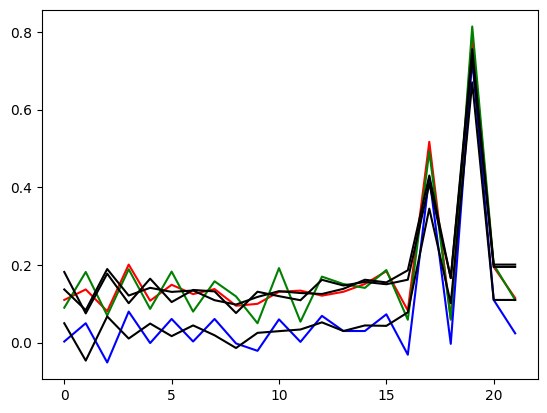

In [207]:
import matplotlib.pyplot as plt

inputs = feature_extractor.input_from_feature(features)
inputs = inputs[:, 2:] / 1000.
inputs = np.expand_dims(inputs, 0)

plt.plot(inputs[0,:,0], 'r')
plt.plot(inputs[0,:,1], 'g')
plt.plot(inputs[0,:,2], 'b')

inputs = window_slice(inputs)
plt.plot(inputs[0,:,0], 'k')
plt.plot(inputs[0,:,1], 'k')
plt.plot(inputs[0,:,2], 'k')

In [182]:
test = 'A10E8QHPV30BAD	0102f02e052a473f8b5a87f42a9f6c13	Gun Control	oppose	Sat Jun 15 14:09:11 UTC 2013	AMT	Copy_1	AMT	FT	I strongly support gun control being strongly regulated for many different reasons. The main point I would like to make is that the majority of violent crimes that result in death are done using guns. Through the use of gun control, we can eliminate a large portion of these crimes by taking away the weapon. Also, even a person who may not intend on using a gun but carries one with them could potentially end up using a gun as a self-defense mechanism. This happens far too often where a person feels threatened, so they pull out there gun and use it. The problem is that in most of these cases the person would have been just fine without the use of the gun. For these reasons and more, I believe that gun control should be put in place to help reduce crime and increase the security of the American people.	0 MouseUp 0 0;5309 KeyDown 16;5453 KeyDown 73;5576 KeyUp 16;5587 KeyUp 73;5648 KeyDown 32;5788 KeyUp 32;5820 KeyDown 83;5956 KeyUp 83;5973 KeyDown 84;6084 KeyUp 84;6140 KeyDown 82;6259 KeyDown 79;6276 KeyUp 82;6332 KeyDown 78;6388 KeyUp 79;6468 KeyDown 71;6475 KeyUp 78;6527 KeyDown 76;6588 KeyUp 71;6644 KeyUp 76;6671 KeyDown 89;6779 KeyDown 32;6820 KeyUp 89;6900 KeyDown 83;6915 KeyUp 32;6998 KeyDown 85;7020 KeyUp 83;7115 KeyUp 85;7164 KeyDown 80;7428 KeyUp 80;8028 KeyDown 80;8156 KeyDown 79;8173 KeyUp 80;8292 KeyDown 82;8300 KeyUp 79;8396 KeyUp 82;8460 KeyDown 84;8572 KeyDown 32;8588 KeyUp 84;8724 KeyUp 32;8804 KeyDown 71;8892 KeyDown 85;8932 KeyUp 71;8988 KeyUp 85;9085 KeyDown 78;9156 KeyDown 32;9236 KeyUp 78;9308 KeyUp 32;9332 KeyDown 67;9436 KeyDown 79;9453 KeyUp 67;9558 KeyDown 78;9579 KeyUp 79;9587 KeyDown 84;9644 KeyUp 78;9712 KeyUp 84;9768 KeyDown 82;9859 KeyUp 82;9867 KeyDown 79;9967 KeyUp 79;10044 KeyDown 76;10148 KeyDown 32;10188 KeyUp 76;10268 KeyUp 32;10332 KeyDown 66;10436 KeyUp 66;10492 KeyDown 69;10604 KeyDown 73;10611 KeyUp 69;10684 KeyDown 78;10724 KeyUp 73;10745 KeyDown 71;10817 KeyUp 78;10857 KeyDown 32;10869 KeyUp 71;10991 KeyUp 32;11610 KeyDown 83;11723 KeyUp 83;11810 KeyDown 84;11891 KeyUp 84;11951 KeyDown 82;12032 KeyDown 79;12060 KeyUp 82;12116 KeyDown 78;12164 KeyUp 79;12220 KeyDown 71;12227 KeyUp 78;12324 KeyDown 76;12343 KeyUp 71;12421 KeyUp 76;12436 KeyDown 89;12556 KeyDown 32;12596 KeyUp 89;12653 KeyUp 32;12676 KeyDown 82;12757 KeyDown 69;12796 KeyUp 82;12883 KeyUp 69;12972 KeyDown 71;13036 KeyDown 85;13116 KeyUp 71;13131 KeyUp 85;13196 KeyDown 76;13284 KeyDown 65;13345 KeyUp 76;13348 KeyDown 84;13428 KeyUp 65;13492 KeyUp 84;13500 KeyDown 69;13588 KeyUp 69;13692 KeyDown 68;13788 KeyDown 32;13790 KeyUp 68;13904 KeyDown 70;13905 KeyUp 32;13987 KeyDown 79;13997 KeyUp 70;14062 KeyDown 82;14115 KeyUp 79;14148 KeyDown 32;14180 KeyUp 82;14253 KeyUp 32;14284 KeyDown 77;14412 KeyUp 77;14459 KeyDown 65;14572 KeyUp 65;14582 KeyDown 78;14684 KeyUp 78;14780 KeyDown 89;14885 KeyUp 89;14907 KeyDown 32;15004 KeyDown 68;15020 KeyUp 32;15096 KeyDown 73;15118 KeyUp 68;15205 KeyDown 70;15212 KeyUp 73;15284 KeyUp 70;15340 KeyDown 70;15425 KeyUp 70;15427 KeyDown 69;15507 KeyDown 82;15548 KeyUp 69;15596 KeyDown 69;15652 KeyUp 82;15662 KeyDown 78;15707 KeyUp 69;15778 KeyUp 78;15779 KeyDown 84;15860 KeyDown 32;15903 KeyUp 84;15997 KeyUp 32;16030 KeyDown 82;16104 KeyDown 69;16164 KeyUp 82;16177 KeyDown 65;16212 KeyUp 69;16284 KeyUp 65;16303 KeyDown 83;16420 KeyDown 79;16435 KeyUp 83;16492 KeyDown 78;16556 KeyUp 79;16567 KeyDown 83;16612 KeyUp 78;16677 KeyUp 83;16691 KeyDown 190;16764 KeyDown 32;16812 KeyUp 190;16876 KeyUp 32;16926 KeyDown 16;16965 KeyDown 84;17047 KeyUp 16;17104 KeyUp 84;17112 KeyDown 72;17160 KeyDown 69;17228 KeyUp 72;17259 KeyUp 69;17283 KeyDown 32;17396 KeyDown 77;17411 KeyUp 32;17532 KeyUp 77;17565 KeyDown 65;17676 KeyUp 65;17716 KeyDown 73;17820 KeyDown 78;17843 KeyUp 73;17957 KeyDown 32;17979 KeyUp 78;18053 KeyDown 80;18093 KeyUp 32;18147 KeyDown 79;18206 KeyUp 80;18247 KeyDown 73;18324 KeyUp 79;18342 KeyDown 78;18404 KeyUp 73;18459 KeyDown 84;18491 KeyUp 78;18564 KeyDown 32;18588 KeyUp 84;18700 KeyUp 32;18703 KeyDown 16;18774 KeyDown 73;18820 KeyDown 32;18852 KeyUp 16;18891 KeyUp 73;18932 KeyDown 87;18972 KeyUp 32;19012 KeyDown 79;19067 KeyDown 85;19076 KeyUp 87;19135 KeyUp 79;19208 KeyDown 76;19262 KeyUp 85;19324 KeyUp 76;19334 KeyDown 68;19412 KeyDown 32;19451 KeyUp 68;19516 KeyDown 76;19563 KeyUp 32;19579 KeyDown 73;19659 KeyUp 76;19699 KeyUp 73;19772 KeyDown 75;19891 KeyDown 69;19907 KeyUp 75;19979 KeyDown 32;19987 KeyUp 69;20108 KeyDown 84;20125 KeyUp 32;20187 KeyDown 79;20243 KeyUp 84;20262 KeyDown 32;20308 KeyUp 79;20389 KeyUp 32;20443 KeyDown 77;20564 KeyDown 65;20574 KeyUp 77;20646 KeyDown 75;20692 KeyUp 65;20779 KeyUp 75;20796 KeyDown 69;20892 KeyUp 69;20927 KeyDown 32;20987 KeyDown 73;21060 KeyUp 32;21077 KeyDown 83;21116 KeyUp 73;21173 KeyDown 32;21211 KeyUp 83;21258 KeyDown 84;21296 KeyUp 32;21352 KeyDown 72;21360 KeyUp 84;21391 KeyDown 65;21451 KeyUp 72;21452 KeyDown 84;21524 KeyUp 65;21533 KeyDown 32;21556 KeyUp 84;21612 KeyDown 84;21644 KeyUp 32;21700 KeyDown 72;21740 KeyUp 84;21756 KeyDown 69;21795 KeyUp 72;21819 KeyDown 32;21892 KeyUp 69;21980 KeyUp 32;21980 KeyDown 77;22059 KeyUp 77;22075 KeyDown 65;22203 KeyUp 65;22305 KeyDown 74;22435 KeyUp 74;22459 KeyDown 79;22563 KeyDown 82;22579 KeyUp 79;22646 KeyDown 73;22684 KeyUp 82;22756 KeyUp 73;22756 KeyDown 84;22844 KeyDown 89;22899 KeyUp 84;22941 KeyDown 32;22964 KeyUp 89;23019 KeyDown 79;23052 KeyUp 32;23116 KeyDown 70;23176 KeyUp 79;23176 KeyDown 32;23211 KeyUp 70;23319 KeyUp 32;23356 KeyDown 86;23422 KeyDown 73;23459 KeyUp 86;23499 KeyDown 79;23555 KeyUp 73;23627 KeyUp 79;23668 KeyDown 76;23772 KeyDown 69;23812 KeyUp 76;23883 KeyUp 69;23924 KeyDown 78;24044 KeyDown 84;24055 KeyUp 78;24155 KeyDown 32;24172 KeyUp 84;24300 KeyUp 32;24450 KeyDown 67;24557 KeyUp 67;24627 KeyDown 82;24700 KeyDown 73;24757 KeyUp 82;24774 KeyDown 77;24827 KeyUp 73;24863 KeyDown 69;24915 KeyUp 77;24974 KeyDown 83;25011 KeyUp 69;25036 KeyDown 32;25091 KeyUp 83;25147 KeyDown 84;25166 KeyUp 32;25220 KeyDown 72;25275 KeyUp 84;25284 KeyDown 65;25340 KeyUp 72;25355 KeyDown 84;25432 KeyDown 32;25433 KeyUp 65;25469 KeyUp 84;25550 KeyUp 32;25571 KeyDown 82;25619 KeyDown 69;25675 KeyUp 82;25723 KeyDown 83;25756 KeyUp 69;25811 KeyDown 85;25852 KeyUp 83;25907 KeyDown 76;25957 KeyUp 85;26019 KeyDown 84;26052 KeyUp 76;26115 KeyDown 32;26131 KeyUp 84;26211 KeyDown 73;26243 KeyUp 32;26297 KeyDown 78;26340 KeyUp 73;26363 KeyDown 32;26467 KeyUp 78;26467 KeyDown 68;26499 KeyUp 32;26567 KeyUp 68;26619 KeyDown 69;26724 KeyDown 65;26735 KeyUp 69;26820 KeyDown 84;26851 KeyUp 65;26909 KeyDown 72;26996 KeyUp 84;27027 KeyDown 32;27079 KeyUp 72;27163 KeyUp 32;27188 KeyDown 65;27284 KeyDown 82;27332 KeyUp 65;27379 KeyDown 69;27419 KeyUp 82;27505 KeyUp 69;27533 KeyDown 32;27661 KeyUp 32;27661 KeyDown 68;27772 KeyDown 79;27779 KeyUp 68;27827 KeyDown 78;27923 KeyUp 79;27934 KeyDown 69;27993 KeyUp 78;28059 KeyUp 69;28067 KeyDown 32;28187 KeyUp 32;28204 KeyDown 85;28316 KeyUp 85;28316 KeyDown 83;28419 KeyDown 73;28427 KeyUp 83;28499 KeyDown 78;28565 KeyUp 73;28579 KeyDown 71;28650 KeyUp 78;28693 KeyDown 32;28716 KeyUp 71;28827 KeyUp 32;28851 KeyDown 71;28972 KeyUp 71;28986 KeyDown 85;29091 KeyUp 85;29163 KeyDown 78;29300 KeyUp 78;29300 KeyDown 83;29411 KeyUp 83;29459 KeyDown 190;29523 KeyDown 32;29584 KeyUp 190;29658 KeyUp 32;29716 KeyDown 16;29758 KeyDown 84;29859 KeyUp 16;29915 KeyUp 84;29947 KeyDown 72;30019 KeyDown 82;30051 KeyUp 72;30108 KeyDown 79;30116 KeyUp 82;30163 KeyDown 85;30235 KeyUp 79;30245 KeyDown 71;30284 KeyUp 85;30379 KeyDown 72;30396 KeyUp 71;30451 KeyDown 32;30499 KeyUp 72;30516 KeyDown 84;30556 KeyUp 32;30634 KeyDown 72;30686 KeyUp 84;30687 KeyDown 69;30725 KeyUp 72;30761 KeyDown 32;30801 KeyUp 69;30867 KeyDown 85;30884 KeyUp 32;30969 KeyDown 83;31011 KeyUp 85;31027 KeyDown 69;31100 KeyDown 32;31107 KeyUp 83;31148 KeyUp 69;31187 KeyDown 79;31235 KeyUp 32;31325 KeyDown 70;31326 KeyUp 79;31339 KeyDown 32;31387 KeyUp 70;31499 KeyUp 32;31595 KeyDown 67;31693 KeyUp 67;31907 KeyDown 8;32004 KeyUp 8;32059 KeyDown 71;32155 KeyDown 85;32204 KeyUp 71;32243 KeyUp 85;32339 KeyDown 78;32427 KeyDown 32;32491 KeyUp 78;32531 KeyUp 32;32619 KeyDown 67;32725 KeyUp 67;32779 KeyDown 79;32837 KeyDown 78;32896 KeyDown 84;32909 KeyUp 79;32974 KeyUp 78;32991 KeyUp 84;33059 KeyDown 82;33123 KeyDown 79;33157 KeyUp 82;33259 KeyUp 79;33331 KeyDown 76;33460 KeyUp 76;33683 KeyDown 188;33814 KeyDown 32;33856 KeyUp 188;33925 KeyUp 32;34051 KeyDown 87;34107 KeyDown 69;34187 KeyUp 87;34227 KeyUp 69;34235 KeyDown 32;34347 KeyDown 67;34363 KeyUp 32;34467 KeyUp 67;34491 KeyDown 65;34547 KeyDown 78;34611 KeyUp 65;34619 KeyDown 32;34724 KeyUp 78;34763 KeyUp 32;34834 KeyDown 69;34907 KeyDown 76;34923 KeyUp 69;34984 KeyDown 73;35027 KeyUp 76;35115 KeyUp 73;35195 KeyDown 77;35299 KeyDown 73;35326 KeyUp 77;35404 KeyUp 73;35683 KeyDown 78;35771 KeyDown 65;35783 KeyUp 78;35875 KeyDown 84;35903 KeyUp 65;35967 KeyDown 69;35978 KeyUp 84;36059 KeyUp 69;36069 KeyDown 32;36164 KeyUp 32;36164 KeyDown 65;36235 KeyDown 32;36284 KeyUp 65;36339 KeyDown 76;36367 KeyUp 32;36387 KeyDown 65;36475 KeyUp 76;36499 KeyDown 82;36539 KeyUp 65;36595 KeyUp 82;36688 KeyDown 71;36757 KeyUp 71;36779 KeyDown 69;36883 KeyDown 32;36935 KeyUp 69;36992 KeyDown 80;37003 KeyUp 32;37028 KeyDown 79;37115 KeyUp 80;37139 KeyDown 82;37195 KeyUp 79;37228 KeyUp 82;37291 KeyDown 84;37363 KeyDown 73;37419 KeyUp 84;37451 KeyDown 79;37499 KeyUp 73;37557 KeyDown 78;37587 KeyUp 79;37619 KeyDown 32;37691 KeyUp 78;37707 KeyDown 79;37755 KeyUp 32;37804 KeyDown 70;37827 KeyUp 79;37891 KeyUp 70;37905 KeyDown 32;37985 KeyDown 84;38032 KeyUp 32;38104 KeyUp 84;38104 KeyDown 72;38165 KeyDown 69;38207 KeyUp 72;38243 KeyUp 69;38267 KeyDown 83;38331 KeyDown 69;38442 KeyUp 83;38458 KeyUp 69;39236 KeyDown 32;39339 KeyUp 32;39347 KeyDown 67;39459 KeyUp 67;39571 KeyDown 82;39683 KeyDown 73;39715 KeyUp 82;39731 KeyDown 77;39787 KeyUp 73;39860 KeyDown 83;39867 KeyUp 77;39979 KeyUp 83;39987 KeyDown 32;40131 KeyDown 66;40140 KeyUp 32;40252 KeyUp 66;40275 KeyDown 89;40419 KeyUp 89;40603 KeyDown 8;40689 KeyUp 8;40757 KeyDown 8;40836 KeyUp 8;40899 KeyDown 8;40979 KeyUp 8;41035 KeyDown 8;41148 KeyDown 69;41179 KeyUp 8;41259 KeyDown 83;41307 KeyUp 69;41419 KeyUp 83;41476 KeyDown 32;41603 KeyUp 32;41675 KeyDown 66;41779 KeyUp 66;41788 KeyDown 89;41915 KeyDown 32;41923 KeyUp 89;42059 KeyUp 32;42176 KeyDown 84;42277 KeyDown 65;42277 KeyUp 84;42371 KeyDown 75;42394 KeyUp 65;42467 KeyUp 75;42547 KeyDown 73;42627 KeyDown 78;42699 KeyUp 73;42715 KeyDown 71;42749 KeyUp 78;42803 KeyDown 32;42835 KeyUp 71;42907 KeyDown 65;42937 KeyUp 32;43051 KeyUp 65;43069 KeyDown 87;43155 KeyDown 65;43235 KeyUp 87;43268 KeyDown 89;43320 KeyUp 65;43344 KeyDown 32;43396 KeyUp 89;43450 KeyDown 84;43467 KeyUp 32;43524 KeyDown 72;43563 KeyUp 84;43595 KeyDown 69;43635 KeyUp 72;43659 KeyDown 32;43716 KeyUp 69;43795 KeyUp 32;43803 KeyDown 87;43867 KeyDown 69;43931 KeyUp 87;44028 KeyUp 69;44084 KeyDown 65;44243 KeyUp 65;44515 KeyDown 80;44635 KeyDown 79;44659 KeyUp 80;44763 KeyDown 78;44843 KeyUp 79;44924 KeyUp 78;45384 KeyDown 190;45469 KeyDown 32;45515 KeyUp 190;45595 KeyUp 32;45756 KeyDown 16;45860 KeyDown 65;45987 KeyUp 16;46002 KeyUp 65;46076 KeyDown 76;46187 KeyUp 76;46251 KeyDown 83;46267 KeyDown 79;46350 KeyUp 83;46391 KeyUp 79;47003 KeyDown 188;47119 KeyDown 32;47148 KeyUp 188;47251 KeyUp 32;47299 KeyDown 69;47371 KeyUp 69;47493 KeyDown 86;47580 KeyUp 86;47633 KeyDown 69;47739 KeyDown 78;47758 KeyUp 69;47819 KeyDown 32;47908 KeyUp 78;47963 KeyDown 65;47971 KeyUp 32;48043 KeyDown 32;48094 KeyUp 65;48179 KeyUp 32;48547 KeyDown 80;48675 KeyUp 80;48683 KeyDown 69;48756 KeyDown 82;48819 KeyUp 69;48899 KeyUp 82;50059 KeyDown 83;50163 KeyDown 79;50179 KeyUp 83;50267 KeyDown 78;50339 KeyUp 79;50387 KeyDown 32;50459 KeyUp 78;50586 KeyUp 32;50676 KeyDown 87;50736 KeyDown 72;50795 KeyUp 87;50827 KeyDown 79;50875 KeyUp 72;50923 KeyDown 32;50955 KeyUp 79;51027 KeyUp 32;51077 KeyDown 77;51187 KeyUp 77;51188 KeyDown 65;51291 KeyDown 89;51314 KeyUp 65;51387 KeyDown 32;51437 KeyUp 89;51515 KeyUp 32;51587 KeyDown 78;51692 KeyDown 79;51748 KeyUp 78;51811 KeyDown 84;51827 KeyUp 79;51931 KeyDown 32;51947 KeyUp 84;52067 KeyUp 32;52219 KeyDown 73;52331 KeyDown 78;52371 KeyUp 73;52475 KeyUp 78;52539 KeyDown 84;52678 KeyUp 84;52739 KeyDown 69;52828 KeyDown 78;52837 KeyUp 69;52971 KeyUp 78;53228 KeyDown 68;53339 KeyUp 68;53371 KeyDown 32;53461 KeyDown 79;53523 KeyUp 32;53563 KeyDown 78;53628 KeyUp 79;53667 KeyDown 32;53720 KeyUp 78;53776 KeyUp 32;53812 KeyDown 85;53891 KeyDown 83;53915 KeyUp 85;54020 KeyUp 83;54035 KeyDown 73;54099 KeyDown 78;54163 KeyUp 73;54187 KeyDown 71;54213 KeyUp 78;54291 KeyUp 71;54299 KeyDown 32;54387 KeyDown 65;54411 KeyUp 32;54460 KeyDown 32;54491 KeyUp 65;54571 KeyUp 32;54572 KeyDown 71;54653 KeyDown 85;54691 KeyUp 71;54775 KeyUp 85;54851 KeyDown 78;54911 KeyDown 32;54972 KeyUp 78;55014 KeyDown 66;55035 KeyUp 32;55131 KeyDown 85;55147 KeyUp 66;55243 KeyDown 84;55259 KeyUp 85;55363 KeyDown 32;55387 KeyUp 84;55499 KeyUp 32;55555 KeyDown 67;55675 KeyUp 67;55731 KeyDown 65;55855 KeyUp 65;55900 KeyDown 82;55987 KeyUp 82;56044 KeyDown 82;56139 KeyDown 73;56163 KeyUp 82;56235 KeyDown 69;56260 KeyUp 73;56347 KeyDown 83;56387 KeyUp 69;56443 KeyDown 32;56483 KeyUp 83;56555 KeyDown 79;56613 KeyUp 32;56635 KeyDown 78;56699 KeyUp 79;56756 KeyDown 69;56788 KeyUp 78;56878 KeyUp 69;56878 KeyDown 32;57004 KeyUp 32;57019 KeyDown 87;57109 KeyDown 73;57131 KeyUp 87;57219 KeyDown 84;57229 KeyUp 73;57291 KeyDown 72;57347 KeyUp 84;57380 KeyDown 32;57412 KeyUp 72;57491 KeyUp 32;57492 KeyDown 84;57556 KeyDown 72;57595 KeyUp 84;57660 KeyUp 72;57661 KeyDown 69;57769 KeyDown 77;57779 KeyUp 69;57867 KeyDown 32;57904 KeyUp 77;57956 KeyDown 67;57972 KeyUp 32;58063 KeyDown 79;58099 KeyUp 67;58139 KeyDown 85;58171 KeyUp 79;58268 KeyDown 76;58283 KeyUp 85;58331 KeyDown 68;58379 KeyUp 76;58435 KeyUp 68;58867 KeyDown 32;58964 KeyUp 32;59022 KeyDown 80;59109 KeyDown 79;59157 KeyUp 80;59259 KeyUp 79;59421 KeyDown 69;59499 KeyUp 69;59715 KeyDown 8;59803 KeyUp 8;59821 KeyDown 84;59907 KeyUp 84;59940 KeyDown 69;60036 KeyDown 78;60062 KeyUp 69;60165 KeyUp 78;60476 KeyDown 84;60571 KeyDown 73;60603 KeyUp 84;60671 KeyUp 73;60678 KeyDown 65;60747 KeyDown 76;60779 KeyUp 65;60829 KeyUp 76;60875 KeyDown 76;60979 KeyDown 89;61003 KeyUp 76;61118 KeyDown 32;61172 KeyUp 89;61267 KeyUp 32;61460 KeyDown 69;61563 KeyDown 78;61580 KeyUp 69;61683 KeyUp 78;61684 KeyDown 68;61795 KeyDown 32;61820 KeyUp 68;61961 KeyDown 85;61961 KeyUp 32;62011 KeyDown 80;62084 KeyUp 85;62101 KeyDown 32;62182 KeyUp 80;62267 KeyUp 32;62387 KeyDown 85;62467 KeyDown 83;62499 KeyUp 85;62603 KeyDown 73;62612 KeyUp 83;62676 KeyDown 78;62731 KeyUp 73;62763 KeyDown 71;62819 KeyUp 78;62875 KeyUp 71;62883 KeyDown 32;62966 KeyDown 65;62990 KeyUp 32;63068 KeyDown 32;63079 KeyUp 65;63190 KeyDown 71;63209 KeyUp 32;63322 KeyUp 71;63387 KeyDown 85;63495 KeyUp 85;63587 KeyDown 78;63659 KeyDown 32;63739 KeyUp 78;63771 KeyDown 65;63795 KeyUp 32;63851 KeyDown 83;63899 KeyUp 65;63971 KeyDown 32;64003 KeyUp 83;64123 KeyUp 32;64139 KeyDown 65;64250 KeyDown 32;64260 KeyUp 65;64395 KeyUp 32;64403 KeyDown 83;64515 KeyUp 83;64555 KeyDown 69;64683 KeyUp 69;64691 KeyDown 76;64789 KeyDown 70;64819 KeyUp 76;64915 KeyUp 70;65012 KeyDown 173;65139 KeyDown 68;65163 KeyUp 173;65239 KeyUp 68;65293 KeyDown 69;65387 KeyUp 69;65460 KeyDown 70;65563 KeyUp 70;65574 KeyDown 69;65691 KeyDown 78;65699 KeyUp 69;65835 KeyUp 78;65859 KeyDown 67;65947 KeyUp 67;66204 KeyDown 8;66292 KeyUp 8;66292 KeyDown 83;66358 KeyDown 69;66451 KeyUp 83;66475 KeyUp 69;66499 KeyDown 32;66603 KeyUp 32;66691 KeyDown 77;66747 KeyDown 69;66819 KeyUp 77;66851 KeyUp 69;66955 KeyDown 67;67062 KeyDown 72;67083 KeyUp 67;67155 KeyUp 72;67167 KeyDown 65;67268 KeyDown 78;67275 KeyUp 65;67355 KeyDown 73;67381 KeyUp 78;67494 KeyUp 73;67571 KeyDown 83;67667 KeyDown 77;67675 KeyUp 83;67815 KeyUp 77;67859 KeyDown 190;67939 KeyDown 32;67990 KeyUp 190;68059 KeyUp 32;68112 KeyDown 16;68163 KeyDown 84;68243 KeyUp 16;68299 KeyUp 84;68349 KeyDown 72;68435 KeyDown 73;68479 KeyUp 72;68524 KeyUp 73;68525 KeyDown 83;68603 KeyDown 32;68619 KeyUp 83;68723 KeyUp 32;68795 KeyDown 72;68891 KeyUp 72;68909 KeyDown 65;69019 KeyDown 80;69035 KeyUp 65;69099 KeyUp 80;69155 KeyDown 80;69268 KeyDown 69;69275 KeyUp 80;69371 KeyDown 78;69429 KeyUp 69;69494 KeyDown 83;69504 KeyUp 78;69569 KeyDown 32;69611 KeyUp 83;69701 KeyUp 32;69731 KeyDown 70;69835 KeyUp 70;69868 KeyDown 65;69924 KeyDown 82;70003 KeyUp 65;70051 KeyUp 82;70083 KeyDown 32;70148 KeyDown 84;70204 KeyUp 32;70243 KeyDown 79;70269 KeyUp 84;70331 KeyUp 79;70387 KeyDown 79;70492 KeyDown 32;70493 KeyUp 79;70579 KeyDown 79;70614 KeyUp 32;70667 KeyDown 70;70707 KeyUp 79;70755 KeyUp 70;70803 KeyDown 84;70923 KeyUp 84;70948 KeyDown 69;71075 KeyDown 78;71086 KeyUp 69;71155 KeyDown 32;71219 KeyUp 78;71275 KeyDown 87;71292 KeyUp 32;71371 KeyDown 72;71426 KeyUp 87;71429 KeyDown 69;71499 KeyUp 72;71540 KeyDown 82;71570 KeyUp 69;71622 KeyDown 69;71663 KeyUp 82;71721 KeyDown 32;71745 KeyUp 69;71811 KeyDown 65;71827 KeyUp 32;71891 KeyDown 32;71933 KeyUp 65;72011 KeyUp 32;72187 KeyDown 80;72331 KeyUp 80;72363 KeyDown 69;72427 KeyDown 82;72492 KeyUp 69;72599 KeyUp 82;72599 KeyDown 83;72740 KeyUp 83;72756 KeyDown 79;72827 KeyDown 78;72883 KeyUp 79;72915 KeyDown 32;73019 KeyUp 78;73043 KeyDown 70;73063 KeyUp 32;73147 KeyUp 70;73195 KeyDown 69;73300 KeyUp 69;73355 KeyDown 69;73468 KeyUp 69;73491 KeyDown 76;73571 KeyDown 83;73595 KeyUp 76;73704 KeyUp 83;73715 KeyDown 32;73844 KeyUp 32;73851 KeyDown 84;73955 KeyUp 84;73979 KeyDown 72;74060 KeyDown 82;74101 KeyUp 72;74131 KeyDown 69;74203 KeyUp 82;74259 KeyUp 69;74364 KeyDown 65;74499 KeyUp 65;74563 KeyDown 84;74687 KeyUp 84;74732 KeyDown 69;74861 KeyUp 69;74875 KeyDown 78;74979 KeyUp 78;75011 KeyDown 69;75115 KeyUp 69;75251 KeyDown 68;75371 KeyUp 68;75403 KeyDown 188;75567 KeyDown 32;75595 KeyUp 188;75651 KeyDown 83;75683 KeyUp 32;75732 KeyDown 79;75789 KeyUp 83;75809 KeyDown 32;75860 KeyUp 79;75893 KeyDown 84;75926 KeyUp 32;75972 KeyDown 72;76011 KeyUp 84;76052 KeyDown 69;76065 KeyUp 72;76147 KeyDown 89;76187 KeyUp 69;76242 KeyDown 32;76283 KeyUp 89;76342 KeyDown 80;76363 KeyUp 32;76437 KeyDown 85;76475 KeyUp 80;76555 KeyUp 85;76603 KeyDown 76;76707 KeyUp 76;76774 KeyDown 76;76845 KeyDown 32;76891 KeyUp 76;76971 KeyDown 79;76991 KeyUp 32;77075 KeyDown 85;77131 KeyUp 79;77219 KeyUp 85;77466 KeyDown 84;77611 KeyUp 84;77707 KeyDown 32;77859 KeyDown 84;77860 KeyUp 32;77917 KeyDown 72;77964 KeyUp 84;78012 KeyDown 69;78052 KeyUp 72;78131 KeyUp 69;79299 KeyDown 82;79427 KeyUp 82;80018 KeyDown 69;80123 KeyUp 69;80171 KeyDown 32;80291 KeyDown 71;80307 KeyUp 32;80379 KeyDown 85;80443 KeyUp 71;80475 KeyUp 85;80555 KeyDown 78;80659 KeyDown 32;80715 KeyUp 78;80723 KeyDown 65;80787 KeyUp 32;80867 KeyDown 78;80947 KeyUp 65;80996 KeyDown 68;81021 KeyUp 78;81104 KeyDown 32;81141 KeyUp 68;81227 KeyDown 85;81243 KeyUp 32;81338 KeyUp 85;81363 KeyDown 83;81459 KeyDown 69;81539 KeyUp 83;81582 KeyDown 32;81599 KeyUp 69;81691 KeyDown 73;81755 KeyUp 32;81811 KeyDown 84;81825 KeyUp 73;81931 KeyUp 84;81979 KeyDown 190;82079 KeyDown 32;82119 KeyUp 190;82227 KeyUp 32;82443 KeyDown 16;82515 KeyDown 84;82603 KeyUp 16;82667 KeyUp 84;82683 KeyDown 72;82771 KeyDown 69;82814 KeyUp 72;82827 KeyDown 32;82891 KeyUp 69;82899 KeyDown 80;82947 KeyUp 32;83033 KeyDown 82;83034 KeyUp 80;83101 KeyDown 79;83116 KeyUp 82;83211 KeyDown 66;83219 KeyUp 79;83323 KeyDown 76;83347 KeyUp 66;83427 KeyDown 69;83435 KeyUp 76;83531 KeyDown 77;83547 KeyUp 69;83604 KeyDown 32;83660 KeyUp 77;83691 KeyDown 73;83734 KeyUp 32;83763 KeyDown 83;83795 KeyUp 73;83852 KeyUp 83;83860 KeyDown 32;83907 KeyDown 84;83973 KeyUp 32;84011 KeyDown 72;84043 KeyUp 84;84096 KeyDown 65;84141 KeyUp 72;84141 KeyDown 84;84207 KeyUp 65;84227 KeyDown 32;84259 KeyUp 84;84339 KeyDown 73;84371 KeyUp 32;84419 KeyDown 78;84459 KeyUp 73;84492 KeyDown 32;84555 KeyUp 78;84604 KeyUp 32;84675 KeyDown 77;84731 KeyDown 79;84787 KeyUp 77;84835 KeyDown 83;84883 KeyUp 79;84931 KeyDown 84;84995 KeyUp 83;85018 KeyDown 32;85067 KeyUp 84;85068 KeyDown 79;85136 KeyUp 32;85195 KeyDown 70;85218 KeyUp 79;85233 KeyDown 32;85279 KeyUp 70;85336 KeyDown 84;85348 KeyUp 32;85393 KeyDown 72;85435 KeyDown 69;85460 KeyUp 84;85518 KeyUp 72;85531 KeyUp 69;85543 KeyDown 83;85629 KeyDown 69;85683 KeyUp 83;85758 KeyDown 32;85764 KeyUp 69;85875 KeyUp 32;85915 KeyDown 67;86045 KeyUp 67;86075 KeyDown 65;86161 KeyDown 83;86215 KeyUp 65;86243 KeyDown 69;86317 KeyUp 83;86371 KeyUp 69;86411 KeyDown 83;86547 KeyUp 83;86763 KeyDown 32;86867 KeyDown 84;86883 KeyUp 32;86944 KeyDown 72;86995 KeyUp 84;87027 KeyDown 69;87075 KeyUp 72;87091 KeyDown 32;87139 KeyUp 69;87275 KeyUp 32;87323 KeyDown 80;87411 KeyDown 69;87435 KeyUp 80;87492 KeyDown 82;87555 KeyUp 69;87627 KeyDown 83;87652 KeyUp 82;87707 KeyDown 79;87771 KeyUp 83;87795 KeyDown 78;87843 KeyUp 79;87891 KeyDown 32;87979 KeyUp 78;88035 KeyUp 32;88083 KeyDown 70;88187 KeyUp 70;88227 KeyDown 69;88339 KeyUp 69;88387 KeyDown 69;88483 KeyUp 69;88491 KeyDown 76;88587 KeyDown 83;88628 KeyUp 76;88731 KeyUp 83;89819 KeyDown 8;89907 KeyUp 8;89995 KeyDown 8;90083 KeyUp 8;90163 KeyDown 8;90253 KeyUp 8;90611 KeyDown 8;90707 KeyUp 8;90756 KeyDown 8;90891 KeyUp 8;91027 KeyDown 87;91131 KeyDown 79;91163 KeyUp 87;91215 KeyDown 85;91259 KeyUp 79;91323 KeyDown 76;91403 KeyUp 85;91428 KeyDown 68;91460 KeyUp 76;91526 KeyDown 32;91526 KeyUp 68;91667 KeyDown 72;91683 KeyUp 32;91779 KeyDown 65;91811 KeyUp 72;91875 KeyUp 65;91923 KeyDown 86;92019 KeyUp 86;92067 KeyDown 69;92163 KeyDown 32;92179 KeyUp 69;92283 KeyDown 66;92299 KeyUp 32;92405 KeyUp 66;92491 KeyDown 69;92586 KeyUp 69;92643 KeyDown 69;92675 KeyDown 78;92750 KeyUp 69;92795 KeyDown 32;92843 KeyUp 78;92931 KeyUp 32;93093 KeyDown 74;93171 KeyUp 74;93236 KeyDown 85;93338 KeyDown 83;93351 KeyUp 85;93419 KeyDown 84;93459 KeyUp 83;93507 KeyDown 32;93539 KeyUp 84;93622 KeyDown 70;93659 KeyUp 32;93707 KeyDown 73;93744 KeyUp 70;93803 KeyDown 78;93835 KeyDown 69;93843 KeyUp 73;93923 KeyUp 78;93972 KeyUp 69;93986 KeyDown 32;94053 KeyDown 87;94107 KeyUp 32;94147 KeyDown 73;94190 KeyUp 87;94251 KeyUp 73;94275 KeyDown 84;94339 KeyDown 72;94435 KeyUp 84;94458 KeyDown 79;94459 KeyUp 72;94552 KeyDown 85;94615 KeyUp 79;94660 KeyDown 84;94687 KeyUp 85;94787 KeyUp 84;94787 KeyDown 32;94899 KeyDown 84;94907 KeyUp 32;94979 KeyDown 72;95052 KeyUp 84;95083 KeyDown 69;95132 KeyUp 72;95171 KeyDown 32;95211 KeyUp 69;95299 KeyUp 32;95339 KeyDown 85;95435 KeyDown 83;95467 KeyUp 85;95531 KeyDown 69;95635 KeyUp 83;95671 KeyUp 69;95676 KeyDown 32;95843 KeyUp 32;95923 KeyDown 79;95995 KeyDown 70;96044 KeyUp 79;96095 KeyDown 32;96100 KeyUp 70;96163 KeyDown 84;96195 KeyUp 32;96243 KeyDown 72;96292 KeyUp 84;96307 KeyDown 69;96347 KeyUp 72;96387 KeyDown 32;96411 KeyUp 69;96499 KeyUp 32;96507 KeyDown 71;96587 KeyDown 85;96603 KeyUp 71;96712 KeyUp 85;96780 KeyDown 78;96883 KeyUp 78;96976 KeyDown 190;97067 KeyDown 32;97115 KeyUp 190;97195 KeyUp 32;97283 KeyDown 16;97467 KeyDown 84;97611 KeyUp 84;97627 KeyUp 16;97822 KeyDown 8;97924 KeyUp 8;98069 KeyDown 16;98117 KeyDown 70;98197 KeyUp 16;98259 KeyUp 70;98290 KeyDown 79;98403 KeyUp 79;98403 KeyDown 82;98499 KeyDown 32;98516 KeyUp 82;98579 KeyDown 84;98606 KeyUp 32;98643 KeyDown 72;98715 KeyUp 84;98753 KeyDown 69;98771 KeyUp 72;98828 KeyUp 69;98828 KeyDown 83;98980 KeyUp 83;99075 KeyDown 69;99179 KeyUp 69;99563 KeyDown 32;99707 KeyUp 32;99820 KeyDown 82;99903 KeyDown 69;99949 KeyUp 82;100011 KeyUp 69;100051 KeyDown 65;100179 KeyDown 83;100204 KeyUp 65;100307 KeyDown 79;100332 KeyUp 83;100371 KeyDown 78;100452 KeyUp 79;100459 KeyDown 83;100523 KeyUp 78;100572 KeyUp 83;100579 KeyDown 32;100627 KeyDown 65;100683 KeyUp 32;100756 KeyDown 78;100779 KeyUp 65;100819 KeyDown 68;100844 KeyDown 32;100862 KeyUp 78;100950 KeyUp 68;100987 KeyDown 77;101001 KeyUp 32;101027 KeyDown 79;101107 KeyUp 77;101139 KeyDown 82;101163 KeyUp 79;101219 KeyDown 69;101292 KeyUp 82;101339 KeyDown 188;101347 KeyUp 69;101456 KeyDown 32;101483 KeyUp 188;101507 KeyDown 16;101595 KeyUp 32;101611 KeyDown 73;101668 KeyUp 16;101675 KeyDown 32;101755 KeyUp 73;101764 KeyDown 66;101792 KeyUp 32;101908 KeyUp 66;101966 KeyDown 69;102067 KeyDown 76;102079 KeyUp 69;102158 KeyDown 69;102159 KeyDown 73;102219 KeyUp 76;102237 KeyUp 69;102283 KeyUp 73;102367 KeyDown 86;102459 KeyUp 86;102507 KeyDown 69;102595 KeyUp 69;102942 KeyDown 8;103012 KeyUp 8;103075 KeyDown 8;103164 KeyUp 8;103211 KeyDown 8;103307 KeyUp 8;103347 KeyDown 8;103452 KeyUp 8;103563 KeyDown 73;103643 KeyDown 69;103687 KeyUp 73;103733 KeyUp 69;103827 KeyDown 86;103939 KeyUp 86;104331 KeyDown 69;104443 KeyUp 69;104507 KeyDown 32;104635 KeyUp 32;104756 KeyDown 84;104946 KeyUp 84;104946 KeyDown 72;105019 KeyDown 65;105064 KeyUp 72;105108 KeyDown 84;105148 KeyUp 65;105202 KeyDown 32;105243 KeyUp 84;105316 KeyUp 32;105347 KeyDown 71;105404 KeyDown 85;105475 KeyUp 71;105491 KeyUp 85;105587 KeyDown 78;105659 KeyDown 32;105724 KeyUp 78;105755 KeyUp 32;105756 KeyDown 67;105868 KeyDown 79;105909 KeyUp 67;105955 KeyDown 78;105987 KeyDown 84;106002 KeyUp 79;106035 KeyUp 78;106112 KeyUp 84;106184 KeyDown 82;106294 KeyDown 79;106295 KeyUp 82;106379 KeyUp 79;106435 KeyDown 76;106597 KeyUp 76;106643 KeyDown 32;106755 KeyUp 32;106987 KeyDown 83;107053 KeyDown 72;107107 KeyUp 83;107148 KeyDown 79;107166 KeyUp 72;107236 KeyDown 85;107278 KeyUp 79;107324 KeyDown 76;107390 KeyUp 85;107399 KeyDown 68;107451 KeyUp 76;107499 KeyDown 32;107507 KeyUp 68;107595 KeyDown 66;107619 KeyUp 32;107707 KeyUp 66;107763 KeyDown 69;107827 KeyDown 32;107891 KeyUp 69;107915 KeyDown 80;107947 KeyUp 32;108007 KeyDown 85;108059 KeyUp 80;108107 KeyDown 84;108131 KeyUp 85;108187 KeyDown 32;108245 KeyUp 84;108284 KeyDown 73;108316 KeyUp 32;108352 KeyDown 78;108411 KeyDown 32;108419 KeyUp 73;108491 KeyUp 78;108492 KeyDown 80;108539 KeyUp 32;108627 KeyUp 80;108683 KeyDown 76;108763 KeyDown 65;108795 KeyUp 76;108843 KeyUp 65;108915 KeyDown 67;109035 KeyUp 67;109147 KeyDown 69;109187 KeyDown 32;109211 KeyUp 69;109291 KeyDown 84;109327 KeyUp 32;109347 KeyDown 79;109428 KeyUp 84;109435 KeyDown 32;109467 KeyUp 79;109531 KeyDown 72;109563 KeyUp 32;109647 KeyDown 69;109651 KeyUp 72;109763 KeyUp 69;109771 KeyDown 76;109804 KeyDown 80;109875 KeyUp 76;109923 KeyDown 32;109967 KeyUp 80;110051 KeyDown 82;110067 KeyUp 32;110131 KeyDown 69;110191 KeyUp 82;110227 KeyUp 69;110383 KeyDown 68;110497 KeyUp 68;110518 KeyDown 85;110627 KeyUp 85;110670 KeyDown 67;110756 KeyUp 67;110835 KeyDown 69;110931 KeyUp 69;110957 KeyDown 32;111059 KeyUp 32;111315 KeyDown 67;111438 KeyUp 67;111550 KeyDown 82;111661 KeyUp 82;111707 KeyDown 73;111819 KeyDown 77;111843 KeyUp 73;111923 KeyDown 69;111931 KeyUp 77;112035 KeyDown 32;112046 KeyUp 69;112083 KeyDown 65;112147 KeyUp 32;112211 KeyUp 65;112212 KeyDown 78;112299 KeyDown 68;112308 KeyUp 78;112325 KeyDown 32;112425 KeyUp 68;112450 KeyDown 73;112485 KeyUp 32;112548 KeyDown 78;112559 KeyDown 67;112583 KeyUp 73;112659 KeyUp 78;112691 KeyUp 67;112757 KeyDown 82;112843 KeyDown 69;112900 KeyUp 82;112947 KeyDown 65;112955 KeyUp 69;113083 KeyDown 83;113099 KeyUp 65;113147 KeyDown 69;113227 KeyUp 83;113267 KeyUp 69;113343 KeyDown 32;113489 KeyUp 32;113517 KeyDown 83;113643 KeyUp 83;114019 KeyDown 8;114115 KeyUp 8;114139 KeyDown 84;114267 KeyUp 84;114268 KeyDown 72;114371 KeyUp 72;114380 KeyDown 69;114484 KeyDown 32;114501 KeyUp 69;114635 KeyUp 32;114643 KeyDown 83;114755 KeyUp 83;114891 KeyDown 69;114995 KeyUp 69;115123 KeyDown 67;115227 KeyDown 85;115259 KeyUp 67;115339 KeyUp 85;115363 KeyDown 82;115467 KeyDown 73;115475 KeyUp 82;115594 KeyDown 84;115595 KeyUp 73;115678 KeyDown 89;115722 KeyUp 84;115769 KeyDown 32;115804 KeyUp 89;115933 KeyDown 79;115947 KeyUp 32;116076 KeyUp 79;116076 KeyDown 70;116171 KeyUp 70;116187 KeyDown 32;116243 KeyDown 84;116299 KeyUp 32;116347 KeyDown 72;116387 KeyUp 84;116427 KeyDown 69;116467 KeyUp 72;116495 KeyDown 32;116526 KeyUp 69;116603 KeyUp 32;116666 KeyDown 16;116744 KeyDown 65;116812 KeyUp 16;116875 KeyUp 65;116915 KeyDown 77;116971 KeyDown 69;116995 KeyUp 77;117067 KeyDown 82;117147 KeyUp 69;117179 KeyDown 73;117195 KeyUp 82;117299 KeyUp 73;117307 KeyDown 67;117437 KeyUp 67;117475 KeyDown 65;117547 KeyDown 78;117571 KeyUp 65;117688 KeyDown 32;117742 KeyUp 78;117821 KeyUp 32;118123 KeyDown 80;118227 KeyDown 69;118235 KeyUp 80;118331 KeyDown 79;118356 KeyDown 80;118387 KeyUp 69;118435 KeyUp 79;118491 KeyUp 80;118531 KeyDown 76;118643 KeyUp 76;118651 KeyDown 69;118760 KeyDown 190;118800 KeyUp 69;118865 KeyUp 190;'

In [183]:
test.count('KeyDown'), test.count('KeyUp')

(857, 857)

In [184]:
"text -> 857/2 = 425"

'text -> 857/2 = 425'